In [1]:
import fasttext
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearnex import patch_sklearn
from arabert.preprocess import ArabertPreprocessor

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
patch_sklearn()
sns.set()
tqdm.pandas()
sns.set_style("whitegrid", {"axes.grid": False})
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [4]:
fasttext_model_path = "../models/cc.ar.300.bin"
processing_model = "aubmindlab/bert-base-arabertv2"
labeled_data_path = "../data/processed/to_label.json"

In [5]:
encoder = fasttext.load_model(fasttext_model_path)

In [6]:
arabert_prep = ArabertPreprocessor(model_name=processing_model)

[2023-11-16 01:39:18,179 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [7]:
dataset = pd.read_json(labeled_data_path)
dataset.head(2)

,tweetid,tweet_text,text,tech,label
0,295735762505322497,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,None,0
1,1080873494227886086,RT @rood516: عرض الاجازه😍👌🏻1\nســــاعه\nقـــلم...,RT : عرض الاجازه1 ســــاعه قـــلم كــبك نظـــا...,None,0


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2100 entries, 0 to 2099
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetid     2100 non-null   int64 
 1   tweet_text  2100 non-null   object
 2   text        2100 non-null   object
 3   tech        202 non-null    object
 4   label       2100 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 98.4+ KB


In [9]:
def process_text(text):
    """Process tweet text by removing links, mentions, and hashtags symbol."""
    clean_text = arabert_prep.preprocess(text)
    clean_text = arabert_prep.unpreprocess(clean_text)
    clean_text = clean_text.replace("[رابط]", "")
    clean_text = clean_text.replace("[مستخدم]", "")
    clean_text = clean_text.replace("RT", "")
    clean_text = clean_text.replace(":", "")
    return clean_text.strip()

In [10]:
dataset["text"] = dataset.text.apply(process_text)
dataset.head(2)

,tweetid,tweet_text,text,tech,label
0,295735762505322497,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,None,0
1,1080873494227886086,RT @rood516: عرض الاجازه😍👌🏻1\nســــاعه\nقـــلم...,عرض الاجازه 1 ساعه قلم كبك نظاره سبحه ميداليه ...,None,0


In [11]:
vectors = []
for t in tqdm(dataset.text.to_list(), total=len(dataset)):
    vectors.append(list(encoder.get_sentence_vector(t)))

dataset["vector"] = vectors

  0%|          | 0/2100 [00:00<?, ?it/s]

In [12]:
label_names = ["Transparent", "Propaganda"]

In [13]:
label2id = {label_names[i]: i for i in range(len(label_names))}
id2label = {i: label_names[i] for i in range(len(label_names))}

In [14]:
train, valid = train_test_split(
    dataset, test_size=0.4, random_state=42, stratify=dataset.label
)
valid, test = train_test_split(
    valid, test_size=0.5, random_state=42, stratify=valid.label
)

In [15]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

In [16]:
test.head(2)

,tweetid,tweet_text,text,tech,label,vector
0,977553193814122498,شاركوا معنا .. في #ساعة_الأرض الليلة \nساعة وا...,شاركوا معنا.. في ساعة الأرض الليلة ساعة واحد ف...,None,0,"[0.00050849526, 0.0056899013, -0.013611543, 0...."
1,1005856990436970497,RT @qtfcjohz: َاللهم طهر قلوبنا من كل ضيق \nوي...,اللهم طهر قلوبنا من كل ضيق ويسر أمورنا في كل ط...,None,0,"[-0.023397544, 0.004370229, -0.04490937, 0.011..."


In [17]:
w = train.label.value_counts(normalize=True).to_list()
w = {i: w[i] for i in range(len(w))}
w

{0: 0.903968253968254, 1: 0.09603174603174604}

In [18]:
def objective(trial):
    p = trial.suggest_categorical("penalty", ["l1", "l2"])
    s = trial.suggest_categorical("solver", ["liblinear"])
    c = trial.suggest_categorical("C", [0.1, 1.0, 10.0, 100.0, 1000.0])
    model = LogisticRegression(
        penalty=p, solver=s, C=c, class_weight=w, max_iter=1000, random_state=42
    )
    model.fit(train.vector.to_list(), train.label.to_list())
    # acc = model.score(x_test, y_test)
    f1 = f1_score(
        valid.label.to_list(),
        model.predict(valid.vector.to_list()),
        average="binary",
    )
    return f1

In [19]:
study = optuna.create_study(study_name="baseline", direction="maximize")
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
model = LogisticRegression(
    class_weight=w, random_state=42, max_iter=1000, **study.best_params
)
model.fit(train.vector.to_list(), train.label.to_list())

LogisticRegression(C=1000.0,
                   class_weight={0: 0.903968253968254, 1: 0.09603174603174604},
                   max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

In [21]:
preds_test = model.predict(test.vector.to_list())

In [22]:
print(classification_report(test.label.to_list(), preds_test, target_names=label_names))

              precision    recall  f1-score   support

 Transparent       0.94      0.93      0.94       380
  Propaganda       0.42      0.47      0.45        40

    accuracy                           0.89       420
   macro avg       0.68      0.70      0.69       420
weighted avg       0.89      0.89      0.89       420



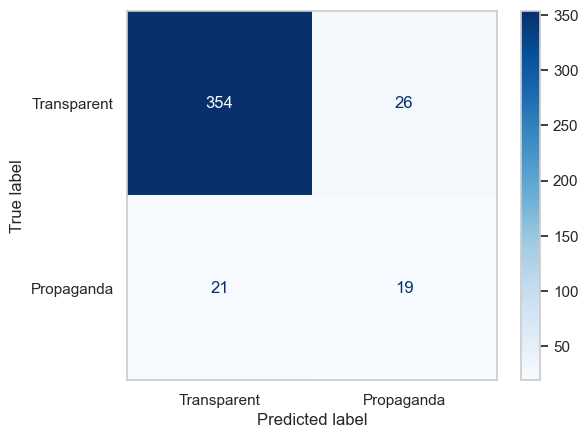

In [23]:
cm = confusion_matrix(test.label.to_list(), preds_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(cmap="Blues")
plt.show()